In [51]:
#import relevant packages
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import panel as pn
import os
from pathlib import Path
from dotenv import load_dotenv
from datetime import date, datetime

pn.extension('plotly')

import hvplot.pandas

In [52]:
#import climate data
climate_df = pd.read_csv('data/raw_climate_data.csv')

#drop index column
climate_df = climate_df.drop(climate_df.columns[0], axis = 1)
#convert date column to datetime
climate_df['Date'] = pd.to_datetime(climate_df['Date'])

#set date to index
climate_df = climate_df.set_index(['Date'])

climate_df.head()

#pull out only pm10 data
pm_10 = climate_df[climate_df['Specie']=='so2']




climate_df['Specie'].unique()

array(['no2', 'humidity', 'wind speed', 'pressure', 'so2', 'pm25', 'o3',
       'dew', 'temperature', 'wind-speed', 'wind-gust', 'co', 'pm10',
       'wind gust', 'wd', 'precipitation', 'aqi', 'pol', 'neph'],
      dtype=object)

<AxesSubplot:xlabel='Date'>

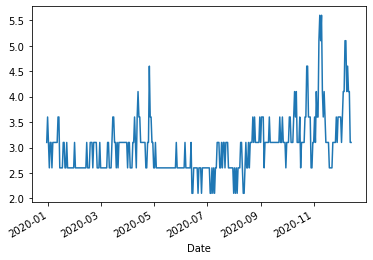

In [53]:
#create dataframe for each country

india = pm_10[pm_10['Country']=='IN']
china = pm_10[pm_10['Country']=='CN']
united_kingdom = pm_10[pm_10['Country']=='GB']
unitied_states = pm_10[pm_10['Country']=='US']
australia = pm_10[pm_10['Country']=='AU']
japan = pm_10[pm_10['Country']=='JP']

shenzen = china[china['City']=='Shenzhen']
shenzen['median'].plot()

In [55]:
# Average PM10 India
india_graph = india.groupby('Date')['median'].mean().hvplot(title = "PM 10",label = 'India')
china_graph = china.groupby('Date')['median'].mean().hvplot(label = 'China')
uk_graph = united_kingdom.groupby('Date')['median'].mean().hvplot(label = 'UK')
us_graph = unitied_states.groupby('Date')['median'].mean().hvplot(label='US')
au_graph = australia.groupby('Date')['median'].mean().hvplot(label='Australia')
jp_graph = japan.groupby('Date')['median'].mean().hvplot(label='Japan')



In [6]:
china.groupby('Date')['median'].mean().rolling(7).mean().hvplot()


:Curve   [Date]   (median)

In [56]:
united_kingdom_countries = {
    'Africa': ['Ghana', 'Togo', 'South Africa'],
    'Asia'  : ['China', 'Thailand', 'Japan'],
    'Europe': ['Austria', 'Bulgaria', 'Greece']
}

continent = pn.widgets.Select(
    value='Asia', 
    options=['Africa', 'Asia', 'Europe']
)

country = pn.widgets.Select(
    value=_countries[continent.value][0], 
    options=countries[continent.value]
)

@pn.depends(continent.param.value)
def _update_countries(continent):
    countries = _countries[continent]
    country.options = countries
    country.value = countries[0]

pn.Row(continent, country)

NameError: name '_countries' is not defined

In [57]:
country_1 = pn.widgets.Select(
    value='China', 
    options=['Japan', 'United Kingdom', 'United States', 'India', 'China', 'Australia']
)

country_2 = pn.widgets.Select(
    value='China', 
    options=['Japan', 'United Kingdom', 'United States', 'India', 'China', 'Australia']
)



pn.Column(pn.Row(country_1, country_2), pn.Row(get_plot(country_1),get_plot(country_2)))

NameError: name 'get_plot' is not defined

In [ ]:
def get_plot(chart):
 
     return chart

In [96]:
# Stock Data
def getYahooData (year):
    start_date = int(datetime(year, 1, 1, 0, 0).timestamp())
    end_date = int(datetime(year+1, 1, 1, 0, 0).timestamp())

    yahoo_url = 'https://query1.finance.yahoo.com/v7/finance/download/{tix}?period1={s}&period2={e}&interval=1d&events=history'
    # get data for 3 tickers and concatenate together
    tickers = ['^GSPC', '^BSESN','000001.SS', '^N225', '^FTSE', '^AXJO']
    df = pd.DataFrame()
    for ticker in tickers:
        url = yahoo_url.format(tix=ticker,s=start_date,e=end_date)
        df_tmp = pd.read_csv(url)
        df_tmp['Ticker'] = ticker
        df_tmp['StockPctChange'] = df_tmp['Close'].pct_change()
        df = pd.concat([df, df_tmp])
    df.to_csv('data/stock_2019.csv')
    # fig = px.line(df, x="Date", y="StockPctChange", color='Ticker')
    # fig.show()
    return df_tmp


In [100]:
country_dict = {'IN' : '^BSESN',
                'CN' : '000001.SS',
                'JP' : '^N225',
                'AU' : '^AXJO',
                'GB' : '^FTSE',
                'US' : '^GSPC'}

def corr_maker(df_stock, climate_df, country='IN', polutant='co'):
    polutant_df = climate_df[climate_df['Specie'] == polutant]
    
    polutant_df_country = polutant_df[polutant_df['Country']== country]['median'].groupby('Date').mean().pct_change()
    df_stock = df[df['Ticker'] == country_dict[country]].set_index('Date')

    df_stock.index = df_stock.index.astype('datetime64[ns]')
    df_stock_polutants = pd.DataFrame({'Date':polutant_df_country.index, 'PolutantPctChange':polutant_df_country.values})
    df_stock_polutants.set_index('Date', inplace=True)
    df_stock_polutants = df_stock_polutants[~df_stock_polutants.index.duplicated(keep='first')]   
    
    df_stock_concat = pd.concat([df_stock, df_stock_polutants], join='inner', axis=1)
    # df_stock_concat = df_stock_concat[['StockPctChange', 'PolutantPctChange']]

    corrSeries = df_stock_concat['StockPctChange'].rolling(20).corr(df_stock_concat['PolutantPctChange'])
    corrDf = pd.DataFrame({'Date':corrSeries.index, 'Corr':corrSeries.values})
    # print(corrSeries)
#     corrDf.columns = ['Date', 'Corr']
    # print(corr)
    # bx = corrSeries.plot()
#     print(corrSeries.tail())
#     bx = px.scatter_matrix(corrDf , color='PolutantPctChange')
    return corrDf


In [101]:
df_stock_2020 = getYahooData(2020)
# TODO: climate_df_2020 = getClimateDate(2020)
corr_df_2020 = corr_maker(df_stock_2020, climate_df)
corr_df_2020.sample(10)
# TODO: climate_df_2019 = getClimateDate(2019)
# corr_df_2019 = corr_maker(df_stock_2019, climate_df_2019)
# corr_df_2019.sample(10)


,Date,Corr
185,2020-09-25,-0.107913
148,2020-08-05,-0.191919
142,2020-07-28,-0.136142
113,2020-06-17,-0.271105
125,2020-07-03,-0.280329
193,2020-10-08,-0.058993
10,2020-01-14,NaN
132,2020-07-14,0.059269
178,2020-09-16,-0.010948
48,2020-03-09,0.150488


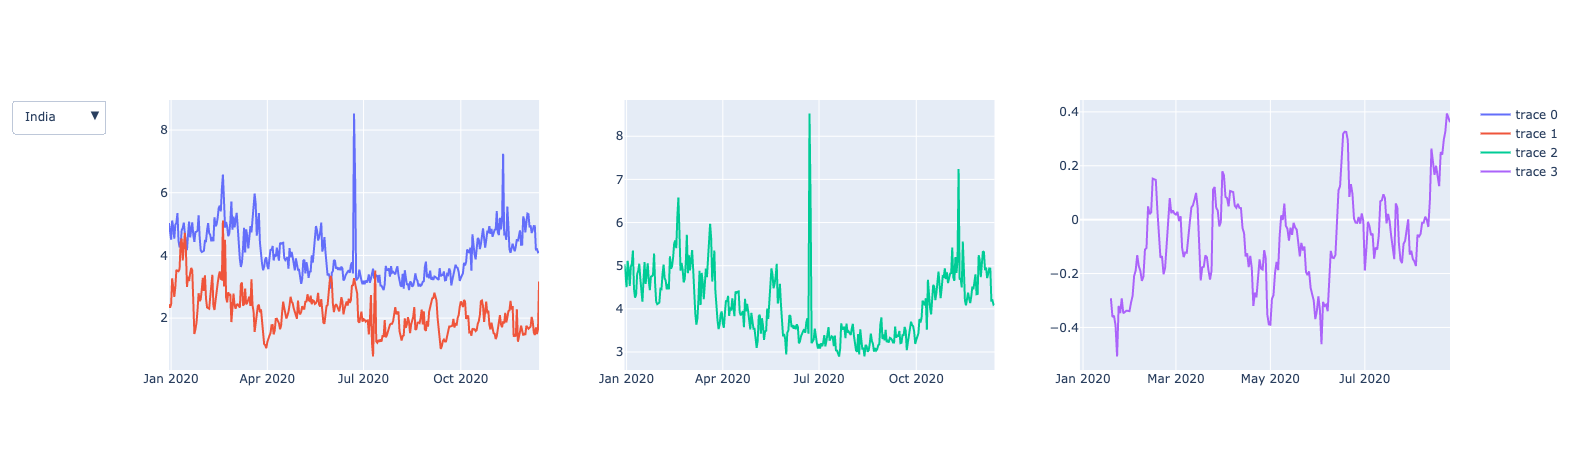

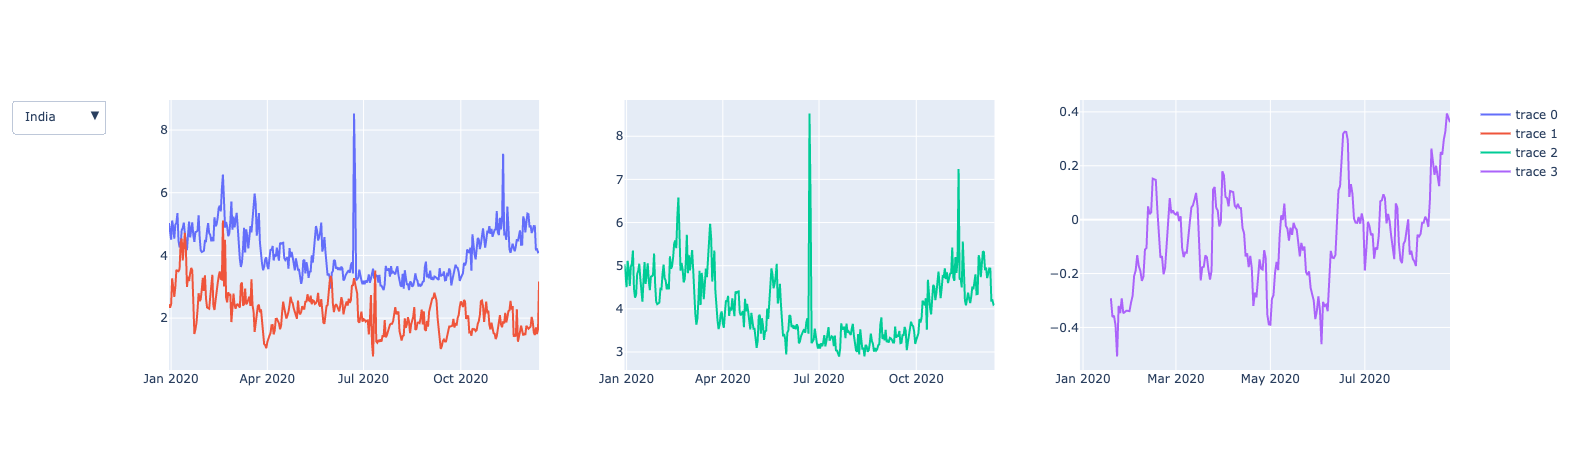

Row
    [0] Str(None)
    [1] Str(None)

In [111]:
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots

# data
#x = list(np.linspace(-np.pi, np.pi, 100))
values_1 = india.groupby('Date')['median'].mean()
#values_1b = [elem*-1 for elem in values_1]
values_2 = list(china.groupby('Date')['median'].mean())
#values_2b = [elem*-1 for elem in values_2]
values_3 = list(united_kingdom.groupby('Date')['median'].mean())
values_4 = list(unitied_states.groupby('Date')['median'].mean())
values_5 = list(australia.groupby('Date')['median'].mean())
values_6 = list(japan.groupby('Date')['median'].mean())

values_corr_2020 = list(corr_df_2020.groupby('Date')['Corr'].mean())
# TODO: values_corr_2019 = list(corr_df_2019.groupby('Date')['Corr'].mean())

# plotly setup]

fig_2020 = make_subplots(rows=1, cols=3)
# Add one ore more traces
fig_2020.add_trace(go.Scatter(x=values_1.index, y=values_1),row=1, col=1)
fig_2020.add_trace(go.Scatter(x=values_1.index, y=values_3),row=1, col=1)
fig_2020.add_trace(go.Scatter(x=values_1.index, y=values_1),row=1, col=2)
fig_2020.add_trace(go.Scatter(x=values_1.index, y=values_corr_2020),row=1, col=3)

# TODO: fig_2019
fig_2019 = fig_2020

#fig.add_traces(go.Scatter(x=china.index, y=values_1))

# construct menus
updatemenus = [{'buttons': [{'method': 'update',
                             'label': 'India',
                             'args': [{'y': [values_1]},]
                              },
                            {'method': 'update',
                             'label': 'China',
                             'args': [{'y': [values_2]},]},{'method': 'update',
                             'label': 'UK',
                             'args': [{'y': [values_3]},]},{'method': 'update',
                             'label': 'US',
                             'args': [{'y': [values_4]},]},{'method': 'update',
                             'label': 'Australia',
                             'args': [{'y': [values_5]},]},{'method': 'update',
                             'label': 'Japan',
                             'args': [{'y': [values_6]},]}
                           ],
                'direction': 'down',
                'showactive': True,}]

# update layout with buttons, and show the figure
fig_2020.update_layout(updatemenus=updatemenus)


pn.Row(fig_2019.show(),fig_2020.show())

In [ ]:
from datetime import date, datetime
start_date = int(datetime(2018, 1, 1, 0, 0).timestamp())
now = int(datetime.now().timestamp())

# yahoo url template (daily data: 2020-07-24 to 2020-11-25)
yahoo_url = 'https://query1.finance.yahoo.com/v7/finance/download/{tix}?period1={s}&period2={e}&interval=1d&events=history'
# get data for 3 tickers and concatenate together
tickers = ['MSFT']
df = pd.DataFrame()
for ticker in tickers:
    url = yahoo_url.format(tix=ticker,s=start_date,e=now)
    df_tmp = pd.read_csv(url)
    df_tmp['Ticker'] = ticker
    df = pd.concat([df, df_tmp])
    

df = df.set_index('Date')
df['Adj Close'].plot()